# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
import pandas as pd

In [ ]:
import spacy
import random
from collections import Counter
import time
import matplotlib.pyplot as plt
import numpy as np
import json
from statistics import mean
import seaborn as sns
import re
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
# ! pip install openai ## ruins thinsg :(
! pip install openai==0.28
import openai
# ! pip install scientific-information-change
# from scientific_information_change.estimate_similarity import SimilarityEstimator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.2 MB/s eta 0:00:00


In [ ]:
# openai.api_key = "" # New key (project key)
openai.api_key = "" # Old key (user key)

# Functions

In [ ]:
def table_metrics(predictions, binary=True):
    classes = sorted(set([x[0] for x in predictions] + [x[1] for x in predictions]), reverse=True)

    # classes = ['SUPPORTS', 'CONTRADICTS', 'UNRELATED', 'ABSTENTION']

    class_mapping = {label: idx for idx, label in enumerate(classes)}

    actual_values = [class_mapping[item[0]] for item in predictions]
    predicted_values = [class_mapping[item[1]] for item in predictions]

    conf_matrix = confusion_matrix(actual_values, predicted_values, labels=np.arange(len(classes)))
    # print(conf_matrix)

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # print(f1_score(actual_values, predicted_values, average='micro'),
    #       precision_score(actual_values, predicted_values, average='micro'),
    #       recall_score(actual_values, predicted_values, average='micro'))
    # print(precision_score(actual_values, predicted_values, average=None, zero_division=0.0))

    return (f1_score(actual_values, predicted_values, average='micro'),
            f1_score(actual_values, predicted_values, average='macro'),
            # precision_score(actual_values, predicted_values, average='micro'),
            # recall_score(actual_values, predicted_values, average='micro'),
            precision_score(actual_values, predicted_values, average='macro'),
            recall_score(actual_values, predicted_values, average='macro'))

In [ ]:
def big_one(predictions):
    classes = ['SUPPORTS', 'CONTRADICTS', 'UNRELATED']

    # Create a mapping dictionary
    class_mapping = {label: idx for idx, label in enumerate(classes)}

    # Convert actual and predicted values to numeric
    actual_values = [class_mapping[item[0]] for item in predictions]
    predicted_values = [class_mapping[item[1]] for item in predictions]

    # Compute micro F1 score
    micro_f1 = f1_score(actual_values, predicted_values, average='micro')
    print(f'Micro F1 Score: {micro_f1:.4f}')

    # Compute macro F1 score
    macro_f1 = f1_score(actual_values, predicted_values, average='macro')
    print(f'Macro F1 Score: {macro_f1:.4f}')

    # Compute confusion matrix
    conf_matrix = confusion_matrix(actual_values, predicted_values, labels=np.arange(len(classes)))

    # Display confusion matrix
    print(conf_matrix)

    # Display confusion matrix with labels
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def calculate_metrics(predictions):
    # Initialize counters for each class
    class_counts = {'SUPPORTS': {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0},
                    'CONTRADICTS': {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0},
                    'UNRELATED': {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0}}

    match_count = miss_count = 0

    # Iterate through the predictions
    for actual, predicted in predictions:
        if predicted == actual:
            match_count += 1
        else:
            miss_count += 1
            # misses.append((claim, abstract, label, actual))
        for cls in class_counts.keys():
            if actual == predicted == cls:
                class_counts[cls]['tp'] += 1
            elif actual == predicted != cls:
                class_counts[cls]['tn'] += 1
            elif actual == cls and predicted != cls:
                class_counts[cls]['fn'] += 1
            elif actual != cls and predicted == cls:
                class_counts[cls]['fp'] += 1

    # Calculate precision, recall, and accuracy for each class
    metrics_per_class = {}
    confusion_matrices = {}

    for cls, counts in class_counts.items():
        precision = counts['tp'] / (counts['tp'] + counts['fp']) if (counts['tp'] + counts['fp']) > 0 else 0
        recall = counts['tp'] / (counts['tp'] + counts['fn']) if (counts['tp'] + counts['fn']) > 0 else 0
        accuracy = (counts['tp'] + counts['tn']) / sum(counts.values())

        metrics_per_class[cls] = {'precision': precision, 'recall': recall, 'accuracy': accuracy}

        # Confusion matrix
        confusion_matrix = np.array([[counts['tp'], counts['fp']], [counts['fn'], counts['tn']]])
        confusion_matrices[cls] = confusion_matrix

    print("Total:  ", len(predictions))
    print("Matches:", match_count)
    print("Misses: ", miss_count)
    print("Match rate:", match_count / (match_count + miss_count))

    big_one(predictions)

    for cls, metrics in metrics_per_class.items():
        print(f'Class: {cls}')
        print(f'Precision: {metrics["precision"]:.2f}')
        print(f'Recall: {metrics["recall"]:.2f}')
        print(f'Accuracy: {metrics["accuracy"]:.2f}')
        print('Confusion Matrix:')
        print(confusion_matrices[cls])
        print()

In [ ]:
! pip install tqdm
from tqdm import tqdm
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

def perplexity(arr):
    device = 'cuda'
    model_id = 'gpt2-large'
    model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
    tokenizer = GPT2TokenizerFast.from_pretrained(model_id)
    encodings = tokenizer('\n\n'.join(arr), return_tensors='pt')

    max_length = model.config.n_positions
    stride = 512

    lls = []
    for i in tqdm(range(0, encodings.input_ids.size(1), stride)):
        begin_loc = max(i + stride - max_length, 0)
        end_loc = i + stride
        input_ids = encodings.input_ids[:,begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:,:-stride] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            log_likelihood = outputs[0] * stride

        lls.append(log_likelihood)

    ppl = torch.exp(torch.stack(lls).sum() / i)
    return ppl

# Load data

In [ ]:
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/negations_with_scores_gpt4.json') as f:
    items = json.load(f)
negation_to_claim = {}
results = []
for k in items:
  results.append((k, items[k][0], items[k][1]))
  negation_to_claim[items[k][0]] = k

In [ ]:
negations_set = set() ## negation dictionary for processing
for result in results:
  if len(result[2]) < 4 and int(result[2]) >= 90:
    negations_set.add(result[1])


In [ ]:
# Prepare the dataset to iterate through
supports = []
negations = []
counter = 0
corpus = {}
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/dataset/corpus.jsonl') as f_pdf: ###### WILL NEED TO CHANGE NAMES
    for line in f_pdf:
        pdf_parse_dict = json.loads(line)
        corpus[pdf_parse_dict['doc_id']] = pdf_parse_dict
print("Corpus parsed.")

nei = 'NOT_ENOUGH_INFO' # TODO: THIS MIGHT NEED TO BE CHANGED

# Prepare the dataset to iterate through
train = {}
c_train = 0
s_train = 0
nei_train = 0
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/dataset/train.jsonl') as f_pdf:
    for line in f_pdf:
        parse = json.loads(line)
        for i in range(len(parse['doc_ids'])):
          if str(parse['doc_ids'][i]) in parse['evidence']:
            if parse['evidence'][str(parse['doc_ids'][i])][0]['label'] + 'S' == "CONTRADICTS" and parse['claim'] not in negations_set: ## negation checker
              counter += 1
              continue
            temp = {
                'claim': parse['claim'],
                'label': parse['evidence'][str(parse['doc_ids'][i])][0]['label'] + 'S'
            }
          else:
            temp = {
                'claim': parse['claim'],
                'label': nei
            }
            nei_train += 1
          train[parse['doc_ids'][i]] = temp
          if train[parse['doc_ids'][i]]['label'] == 'SUPPORTS':
              supports.append(train[parse['doc_ids'][i]]['claim'])
              s_train += 1
          if train[parse['doc_ids'][i]]['label'] == 'CONTRADICTS':
              negations.append(train[parse['doc_ids'][i]]['claim'])
              c_train += 1
print("\nTrain parsed.")
print('Supports: ', s_train)
print('Negations:', c_train)
print('NEI:\t  ', nei_train)

dev = []
c_dev = 0
s_dev = 0
nei_dev = 0
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/dataset/dev.jsonl') as f_pdf:
    for line in f_pdf:
        parse = json.loads(line)
        for i in range(len(parse['doc_ids'])):
          if str(parse['doc_ids'][i]) in parse['evidence']:
            if parse['evidence'][str(parse['doc_ids'][i])][0]['label'] + 'S' == "CONTRADICTS" and parse['claim'] not in negations_set: ## negation checker
              counter += 1
              continue
            temp = {
                'claim': parse['claim'],
                'label': parse['evidence'][str(parse['doc_ids'][i])][0]['label'] + 'S',
                'id': parse['doc_ids'][i]
            }
          else:
            temp = {
                'claim': parse['claim'],
                'label': nei,
                'id': parse['doc_ids'][i]
            }
            nei_dev += 1
          dev.append(temp)
          if temp['label'] == 'SUPPORTS':
              supports.append(temp['claim'])
              s_dev += 1
          if temp['label'] == 'CONTRADICTS':
              negations.append(temp['claim'])
              c_dev += 1
print("\nDev parsed.")
print('Supports: ', s_dev)
print('Negations:', c_dev)
print('NEI:\t  ', nei_dev)

test = []
c_test = 0
s_test = 0
nei_test = 0
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/dataset/test.jsonl') as f_pdf:
    for line in f_pdf:
        parse = json.loads(line)
        for i in range(len(parse['doc_ids'])):
          if str(parse['doc_ids'][i]) in parse['evidence']:
            if parse['evidence'][str(parse['doc_ids'][i])][0]['label'] + 'S' == "CONTRADICTS" and parse['claim'] not in negations_set: ## negation checker
              counter += 1
              continue
            temp = {
                'claim': parse['claim'],
                'label': parse['evidence'][str(parse['doc_ids'][i])][0]['label'] + 'S',
                'id': parse['doc_ids'][i]
            }
          else:
            temp = {
                'claim': parse['claim'],
                'label': nei,
                'id': parse['doc_ids'][i]
            }
            nei_test += 1
          test.append(temp)
          if temp['label'] == 'SUPPORTS':
              supports.append(temp['claim'])
              s_test += 1
          if temp['label'] == 'CONTRADICTS':
              negations.append(temp['claim'])
              c_test += 1
print("\nTest parsed.")
print('Supports: ', s_test)
print('Negations:', c_test)
print('NEI:\t  ', nei_test)

print("\nDataset Total:")
print('Supports: ', len(supports))
print('Negations:', len(negations))
print("NEI:\t  ", str(nei_train + nei_dev + nei_test))
print("\n" + str(counter), "negations removed.")

train_supports = {}
train_contradicts = {}
train_nei = {}
for key in train.keys():
  if train[key]['label'] == 'SUPPORTS':
    train_supports[key] = train[key]
  if train[key]['label'] == 'CONTRADICTS':
    train_contradicts[key] = train[key]
  if train[key]['label'] == nei:
    train_nei[key] = train[key]

Corpus parsed.

Train parsed.
Supports:  178
Negations: 155
NEI:	   134

Dev parsed.
Supports:  38
Negations: 31
NEI:	   29

Test parsed.
Supports:  35
Negations: 39
NEI:	   17

Dataset Total:
Supports:  251
Negations: 225
NEI:	   180

26 negations removed.


# Citance prediction baseline

In [ ]:
random.seed(22)

intro = "The following are examples of claims from a research paper and the corresponding abstract from the paper they are citing."
supports =  "\nThis is an example of an abstract that SUPPORTS the claim: \n\tSuppporting abstract: {} \n\tClaim: {}"
contradicts = "\nThis is an example of an abstract that CONTRADICTS the claim: \n\tContradicting abstract: {} \n\tClaim: {}"
unrelated = "\nThis is an example of an abstract that is UNRELATED to the claim: \n\tUnrelated abstract: {} \n\tClaim: {}"
query = "\nPlease obey the following: With a specific abstract, please make an estimation whether the abstract SUPPORTS or CONTRADICTS the claim. You must choose SUPPORTS or CONTRADICTS. Please return your answer as only the capitalized token, as well as an explanation or rationale for the answer. \nAbstract: {}\n\tClaim: {}"
# query = "\nPlease obey the following: With no specific abstracts, please make an estimation whether the existing academic literature (and not the abstracts above) SUPPORTS or CONTRADICTS the claim. You must choose SUPPORTS or CONTRADICTS. Please return your answer as only the capitalized token, as well as an explanation or rationale for the answer. \n\tClaim: {}"
# the above query is for with abstracts, the below is for without
# query = "\nGiven a claim, please determine whether the existing academic literature SUPPORTS or CONTRADICTS the claim (even if you cannot reference specific abstracts). Please return your answer as only the capitalized token, as well as an explanation or rationale for the answer. \n\tClaim: {}"

results = []
fails = []
match_count = 0
miss_count = 0
misses = []

for item in dev:
  time.sleep(5)
  key = item['id']
  abstract = corpus[key]['abstract']
  claim = item['claim']
  label = item['label']
  if label == 'UNRELATED':
    continue
  query_string = query.format(abstract, claim)
  # query_string = query.format(claim)

  k, v = random.choice(list(train_supports.items()))
  supports_claim = v['claim']
  supports_abstract = corpus[k]['abstract']
  supports_string = supports.format(supports_abstract, supports_claim)

  k, v = random.choice(list(train_contradicts.items()))
  contradicts_claim = v['claim']
  contradicts_abstract = corpus[k]['abstract']
  contradicts_string = contradicts.format(contradicts_abstract, contradicts_claim)

  k, v = random.choice(list(train_nei.items()))
  nei_claim = v['claim']
  nei_abstract = corpus[k]['abstract']
  unrelated_string = unrelated.format(nei_abstract, nei_claim)

  temp = [supports_string, contradicts_string, unrelated_string]
  random.shuffle(temp)
  prompt = intro + temp[0] + temp[1] + temp[2] + query_string
  # prompt = intro + temp[0] + temp[1] + query_string
  # prompt = query_string
  message = [{"role": "user", "content": prompt}]
  try:
    response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.0)
  except Exception as e:
    print(e)
    continue

  predicted = response.choices[0].message.content
  results.append((label, predicted, claim))

  # if predicted != 'SUPPORTS' and predicted != 'CONTRADICTS' and predicted != 'UNRELATED':
  #   fails.append(results[-1])
  # else:
  #   if predicted == label:
  #     match_count += 1
  #   elif predicted == "SUPPORTS" and label == "CONTRADICTS":
  #     print(claim)
  #     print(negation_to_claim[claim])
  #     print()
  #   else:
  #     miss_count += 1
  #     misses.append((claim, abstract, label, predicted))

# Let's be smart and keep all of our json names and info here

## citance_baseline_w_abs: 12/13 contains e

In [ ]:
obj = json.dumps(results, indent=4)
with open('/content/gdrive/MyDrive/Independent study - Max & Carlos/data/citance_baseline_w_abs.json', 'w') as f:
  f.write(obj)

In [ ]:
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/citance_baseline_w_abs.json') as f:
    results = json.load(f)

In [ ]:
labels = ['CONTRADICTS', 'SUPPORTS', 'AMBIGUOUS']
data = []
true_label = []
for x in results:
  label = x[1].split()[:10]
  label = [''.join(char for char in x if char.isalpha() or char == '_') for x in label]
  matched = False
  for l in labels:
    if l in label:
      label = l
      if label == "AMBIGUOUS":
        label = 'UNRELATED'
      matched = True
      break
  if not matched:
    label = "UNRELATED"
  true_label.append((x[0], label, x[1], x[2]))
  data.append((x[0], label))

Total:   72
Matches: 62
Misses:  10
Match rate: 0.8611111111111112
Micro F1 Score: 0.8611
Macro F1 Score: 0.8584
[[36  1  0]
 [ 9 26  0]
 [ 0  0  0]]


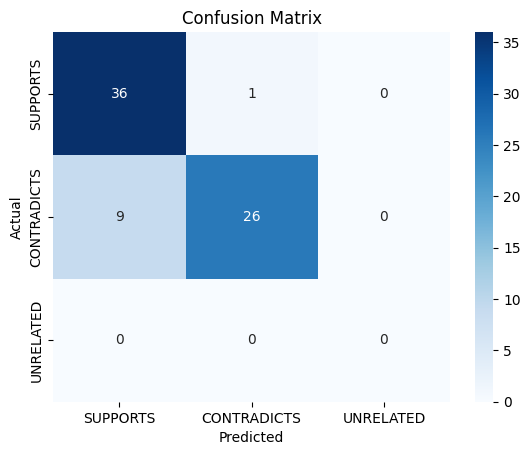

Class: SUPPORTS
Precision: 0.80
Recall: 0.97
Accuracy: 0.86
Confusion Matrix:
[[36  9]
 [ 1 26]]

Class: CONTRADICTS
Precision: 0.96
Recall: 0.74
Accuracy: 0.86
Confusion Matrix:
[[26  1]
 [ 9 36]]

Class: UNRELATED
Precision: 0.00
Recall: 0.00
Accuracy: 1.00
Confusion Matrix:
[[ 0  0]
 [ 0 62]]



In [ ]:
### with evidenec abs
calculate_metrics(data)

Total:   72
Matches: 51
Misses:  21
Match rate: 0.7083333333333334
Micro F1 Score: 0.7083
Macro F1 Score: 0.6812
[[36  1  0]
 [20 15  0]
 [ 0  0  0]]


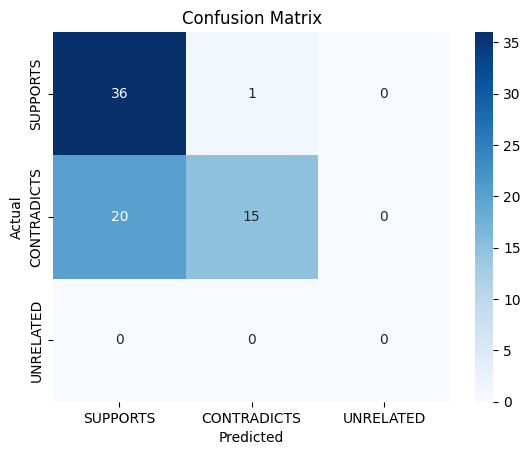

Class: SUPPORTS
Precision: 0.64
Recall: 0.97
Accuracy: 0.71
Confusion Matrix:
[[36 20]
 [ 1 15]]

Class: CONTRADICTS
Precision: 0.94
Recall: 0.43
Accuracy: 0.71
Confusion Matrix:
[[15  1]
 [20 36]]

Class: UNRELATED
Precision: 0.00
Recall: 0.00
Accuracy: 1.00
Confusion Matrix:
[[ 0  0]
 [ 0 51]]



In [ ]:
calculate_metrics(data) # WITH ABSTRACTs

## Zero shot (no in context learning)

Total:   71
Matches: 47
Misses:  24
Match rate: 0.6619718309859155
Micro F1 Score: 0.6620
Macro F1 Score: 0.4397
[[32  4  1]
 [16 15  3]
 [ 0  0  0]]


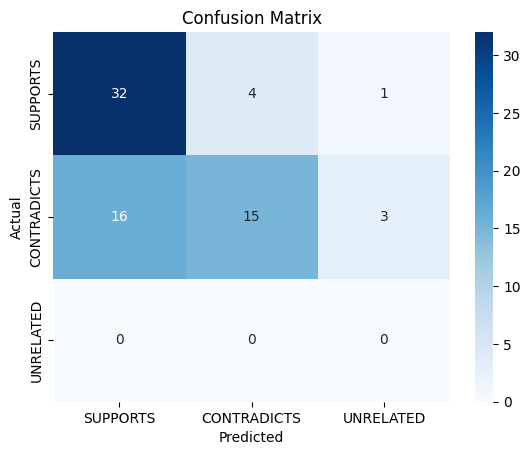

Class: SUPPORTS
Precision: 0.67
Recall: 0.86
Accuracy: 0.69
Confusion Matrix:
[[32 16]
 [ 5 15]]

Class: CONTRADICTS
Precision: 0.79
Recall: 0.44
Accuracy: 0.67
Confusion Matrix:
[[15  4]
 [19 32]]

Class: UNRELATED
Precision: 0.00
Recall: 0.00
Accuracy: 0.92
Confusion Matrix:
[[ 0  4]
 [ 0 47]]



In [ ]:
calculate_metrics(data)

# Analyzing supports

### IMS Support Analysis

In [ ]:
estimator = SimilarityEstimator()
ims_scores = []

for item in dev:
  if item['label'] == "SUPPORTS":
    abs = corpus[item['id']]['abstract']
    abs_string = ""
    val = 0
    claim = item['claim']
    for sent in abs:
      new = estimator.estimate_ims_array(a = [claim], b = [sent])
      if new > val:
        val = new
        abs_string = sent
    ims_scores.append((claim, abs, val, abs_string))

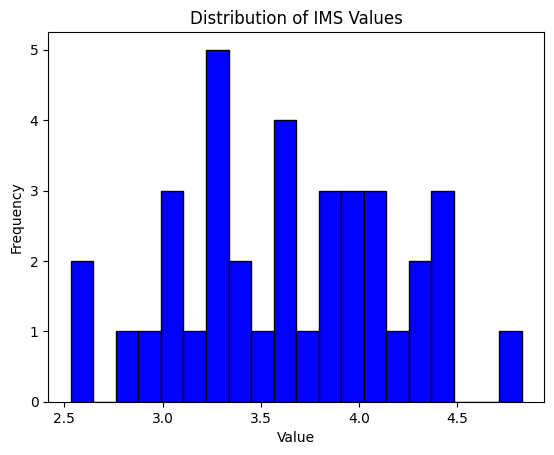

In [ ]:
import matplotlib.pyplot as plt

# Sample data (replace this with your actual data)

# Extract third values from tuples
third_values = [item[2] for item in ims_scores]

# Plotting the distribution graph
plt.hist(third_values, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of IMS Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [ ]:
filtered = [x for x in ims_scores if x[2] > 3.0 and x[2] > 4.2]
for x in filtered:
  print(x[0])
  print(x[3])
  print(x[2])
  print()
  print(x[1])
  print()

The first identified a common variant in the gene DGKK that is strongly associated with risk of hypospadias and has a global minor allele frequency of 0.44 (van der Zanden et al., 2011) .
We propose DGKK as a major risk gene for hypospadias.
4.338125705718994

['Hypospadias is a common congenital malformation of the male external genitalia.', 'We performed a genome-wide association study using pooled DNA from 436 individuals with hypospadias (cases) and 494 controls of European descent and selected the highest ranked SNPs for individual genotyping in the discovery sample, an additional Dutch sample of 133 cases and their parents, and a Swedish series of 266 cases and 402 controls.', 'Individual genotyping of two SNPs (rs1934179 and rs7063116) in DGKK, encoding diacylglycerol kinase κ, produced compelling evidence for association with hypospadias in the discovery sample (allele-specific odds ratio (OR) = 2.5, P = 2.5 × 10−11 and OR = 2.3, P = 2.9 × 10−9, respectively) and in the Dutch (

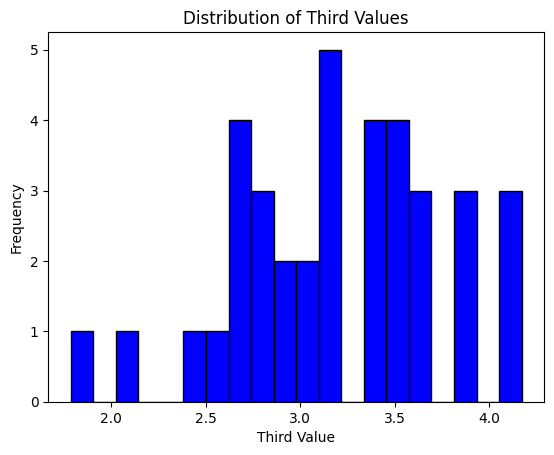

In [ ]:
import matplotlib.pyplot as plt

# Sample data (replace this with your actual data)

# Extract third values from tuples
third_values = [item[2] for item in ims_scores]

# Plotting the distribution graph
plt.hist(third_values, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of IMS Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [ ]:
filtered = [x for x in ims_scores if x[2] < 2.3 and x[2] < 3.5]
filtered

[('Interestingly, recurrent mutations occur frequently within CTCF anchor sites adjacent to oncogenes or cancerassociated genes .',
  ['In this study, we describe the 3D chromosome regulatory landscape of human naive and primed embryonic stem cells.',
   'To devise this map, we identified transcriptional enhancers and insulators in these cells and placed them within the context of cohesin-associated CTCF-CTCF loops using cohesin ChIA-PET data.',
   'The CTCF-CTCF loops we identified form a chromosomal framework of insulated neighborhoods, which in turn form topologically associating domains (TADs) that are largely preserved during the transition between the naive and primed states.',
   'Regulatory changes in enhancer-promoter interactions occur within insulated neighborhoods during cell state transition.',
   'The CTCF anchor regions we identified are conserved across species, influence gene expression, and are a frequent site of mutations in cancer cells, underscoring their functiona

## Weak vs Strong Supports

In [ ]:
random.seed(22)

intro = "The following are examples of claims from a research paper and the corresponding abstract from the paper they are citing."
supports =  "\nThis is an example of an abstract that SUPPORTS the claim: \n\tSuppporting abstract: {} \n\tClaim: {}"
contradicts = "\nThis is an example of an abstract that CONTRADICTS the claim: \n\tContradicting abstract: {} \n\tClaim: {}"
unrelated = "\nThis is an example of an abstract that is UNRELATED to the claim: \n\tUnrelated abstract: {} \n\tClaim: {}"
query = "\nGiven a new abstract and claim pair, determine whether the abstract STRONGLY_SUPPORTS, WEAKLY_SUPPORTS, CONTRADICTS, or is UNRELATED to the claim. Please return your answer as the first token, as well as an explanation and quote from the abstract supporting the rationale for the answer. \n\tNew abstract: {} \n\tClaim: {}"

results = []
fails = []
match_count = 0
miss_count = 0
misses = []

for item in dev:
  time.sleep(5.5)
  key = item['id']
  abstract = corpus[key]['abstract']
  claim = item['claim']
  label = item['label']
  query_string = query.format(abstract, claim)

  k, v = random.choice(list(train_supports.items()))
  supports_claim = v['claim']
  supports_abstract = corpus[k]['abstract']
  supports_string = supports.format(supports_abstract, supports_claim)

  k, v = random.choice(list(train_contradicts.items()))
  contradicts_claim = v['claim']
  contradicts_abstract = corpus[k]['abstract']
  contradicts_string = contradicts.format(contradicts_abstract, contradicts_claim)

  k, v = random.choice(list(train_nei.items()))
  nei_claim = v['claim']
  nei_abstract = corpus[k]['abstract']
  unrelated_string = unrelated.format(nei_abstract, nei_claim)

  temp = [supports_string, contradicts_string, unrelated_string]
  random.shuffle(temp)
  prompt = intro + temp[0] + temp[1] + temp[2] + query_string
  message = [{"role": "user", "content": prompt}]
  try:
    response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.2)
  except Exception as e:
    print(e)
    continue

  predicted = response.choices[0].message.content
  results.append((label, predicted, claim, abstract))

  # if predicted != 'SUPPORTS' and predicted != 'CONTRADICTS' and predicted != 'UNRELATED':
  #   fails.append(results[-1])
  # else:
  #   if predicted == label:
  #     match_count += 1
  #   elif predicted == "SUPPORTS" and label == "CONTRADICTS":
  #     print(claim)
  #     print(negation_to_claim[claim])
  #     print()
  #   else:
  #     miss_count += 1
  #     misses.append((claim, abstract, label, predicted))

## This one below is partial support and unrelated sorta jawn


In [ ]:
random.seed(22)

intro = "The following are examples of claims from a research paper and the corresponding abstract from the paper they are citing."
supports =  "\nThis is an example of an abstract that SUPPORTS the claim: \n\tSuppporting abstract: {} \n\tClaim: {}"
contradicts = "\nThis is an example of an abstract that CONTRADICTS the claim: \n\tContradicting abstract: {} \n\tClaim: {}"
unrelated = "\nThis is an example of an abstract that is UNRELATED to the claim: \n\tUnrelated abstract: {} \n\tClaim: {}"
query = "\nGiven a new abstract and claim pair, determine a label for the pair from the following list: \nSUPPORTS \nPARTIALLY_SUPPORTS \nCONTRADICTS \nUNRELATED \nNOT_ENOUGH_INFORMATION \nPARTIALLY_SUPPORTS means that there are multiple pieces of information in the claim and not all of them have corresponding evidence in the abstract. UNRELATED means the claim and abstract address different topics. NOT_ENOUGH_INFORMATION means the abstract is on the same topic as the claim but there is not enough information to either support or contradict the claim. Please return your answer as the capitalized token, and also provide an explanation and quote from the abstract supporting the rationale for the answer. \n\tNew abstract: {} \n\tClaim: {}"

results = []
fails = []
match_count = 0
miss_count = 0
misses = []

for item in dev:
  time.sleep(5.5)
  key = item['id']
  abstract = corpus[key]['abstract']
  claim = item['claim']
  label = item['label']
  query_string = query.format(abstract, claim)

  k, v = random.choice(list(train_supports.items()))
  supports_claim = v['claim']
  supports_abstract = corpus[k]['abstract']
  supports_string = supports.format(supports_abstract, supports_claim)

  k, v = random.choice(list(train_contradicts.items()))
  contradicts_claim = v['claim']
  contradicts_abstract = corpus[k]['abstract']
  contradicts_string = contradicts.format(contradicts_abstract, contradicts_claim)

  k, v = random.choice(list(train_nei.items()))
  nei_claim = v['claim']
  nei_abstract = corpus[k]['abstract']
  unrelated_string = unrelated.format(nei_abstract, nei_claim)

  temp = [supports_string, contradicts_string, unrelated_string]
  random.shuffle(temp)
  prompt = intro + temp[0] + temp[1] + temp[2] + query_string
  message = [{"role": "user", "content": prompt}]
  try:
    response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.2)
  except Exception as e:
    print(e)
    continue

  predicted = response.choices[0].message.content
  results.append((label, predicted, claim, abstract))

  # if predicted != 'SUPPORTS' and predicted != 'CONTRADICTS' and predicted != 'UNRELATED':
  #   fails.append(results[-1])
  # else:
  #   if predicted == label:
  #     match_count += 1
  #   elif predicted == "SUPPORTS" and label == "CONTRADICTS":
  #     print(claim)
  #     print(negation_to_claim[claim])
  #     print()
  #   else:
  #     miss_count += 1
  #     misses.append((claim, abstract, label, predicted))

In [ ]:
# Write line to file
obj = json.dumps(results, indent=4)
with open('/content/gdrive/MyDrive/Independent study - Max & Carlos/data/partial_testing.json', 'w') as f:
  f.write(obj)

In [ ]:
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/partial_testing.json') as f:
    results = json.load(f)

In [ ]:
labels = ['UNRELATED', 'CONTRADICTS', 'WEAKLY_SUPPORTS', 'STRONGLY_SUPPORTS']
data = []
true_label = []
for x in results:
  label = x[1].split()[:4]
  label = [''.join(char for char in x if char.isalpha() or char == '_') for x in label]
  for l in labels:
    if l in label:
      label = l
      break
  true_label.append((x[0], label, x[1], x[2], x[3]))
  if 'SUPPORTS' in label:
    label = 'SUPPORTS'
  data.append((x[0], label))

IndexError: ignored

In [ ]:
labels = ['UNRELATED', 'CONTRADICTS', 'PARTIALLY_SUPPORTS', 'SUPPORTS', "NOT_ENOUGH_INFORMATION"]
data = []
true_label = []
for x in results:
  label = x[1].split()[:7]
  label = [''.join(char for char in x if char.isalpha() or char == '_') for x in label]
  for l in labels:
    if l in label:
      label = l
      break
  true_label.append((x[0], label, x[1], x[2], x[3]))
  if 'SUPPORTS' in label:
    label = 'SUPPORTS'
  elif "INFORMATION" in label:
    label = "UNRELATED"
    print(true_label[-1][0])
  data.append((x[0], label))

UNRELATED
SUPPORTS
UNRELATED
CONTRADICTS
UNRELATED
CONTRADICTS
SUPPORTS


In [ ]:
counts = Counter(my_list)

# Display the value counts
for item, count in counts.items():
    print(f'{item}: {count}')

In [ ]:
 # Predicted value counts for weak vs strong

Value Counts:
CONTRADICTS: 26
STRONGLY_SUPPORTS: 44
UNRELATED: 36
WEAKLY_SUPPORTS: 6


In [ ]:
for x in true_label:
  if x[1] == 'UNRELATED' and x[0] == 'CONTRADICTS':
    print("Actual label:", x[0])
    print(x[2])
    print("Claim:", x[3])
    print("Abstract:", x[4])
    print()

Actual label: CONTRADICTS
UNRELATED

Explanation: The abstract discusses the structure and formation of the Pleurotolysin (Ply) pore, including the conformational changes in the PlyB component and the role of the TMH2 region. However, it does not specifically mention or discuss an ensemble of conformations not showing the trajectory of β-sheet opening during pore formation, as claimed.

Quote: "The major conformational changes in PlyB are a ∼70° opening of the bent and distorted central β-sheet of the MACPF domain, accompanied by extrusion and refolding of two α-helical regions into transmembrane β-hairpins (TMH1 and TMH2)."
Claim: Segment of a pleurotolysin pore map (~11 Å resolution) with an ensemble of conformations not showing the trajectory of β-sheet opening during pore formation (Lukoyanova et al., 2015).
Abstract: ['Membrane attack complex/perforin-like (MACPF) proteins comprise the largest superfamily of pore-forming proteins, playing crucial roles in immunity and pathogenesis

In [ ]:
# Weakly

Actual label: CONTRADICTS
WEAKLY_SUPPORTS
Explanation: The abstract mentions that granule cell neurons have unique innate immune programs that affect their susceptibility to viral infection. It also mentions that three interferon-stimulated genes (ISGs; Ifi27, Irg1 and Rsad2 (also known as Viperin)) mediate the antiviral effects against different neurotropic viruses. However, it does not specifically mention that lower basal expression and slower up-regulation of IFN-induced genes impairs the survival of granule cell neurons infected by West Nile virus.
Quote: "Granule cell neurons of the cerebellum and cortical neurons from the cerebral cortex have unique innate immune programs that confer differential susceptibility to viral infection ex vivo and in vivo." and "By transducing cortical neurons with genes that were expressed more highly in granule cell neurons, we identified three interferon-stimulated genes (ISGs; Ifi27, Irg1 and Rsad2 (also known as Viperin)) that mediated the antivi

## Calulate metrics

Total:   112
Matches: 96
Misses:  16
Match rate: 0.8571428571428571
Micro F1 Score: 0.8571
Macro F1 Score: 0.8550
[[37  0  0]
 [ 8 25  2]
 [ 5  1 34]]


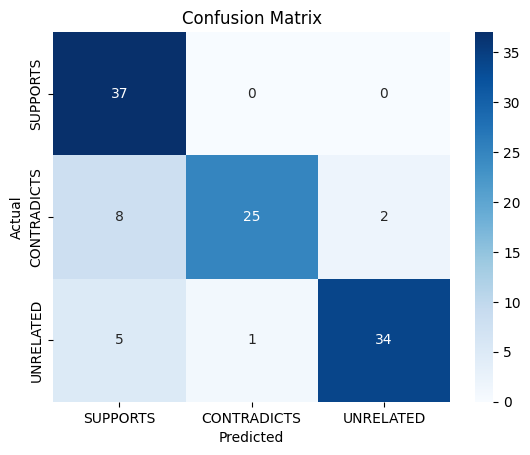

Class: SUPPORTS
Precision: 0.74
Recall: 1.00
Accuracy: 0.88
Confusion Matrix:
[[37 13]
 [ 0 59]]

Class: CONTRADICTS
Precision: 0.96
Recall: 0.71
Accuracy: 0.90
Confusion Matrix:
[[25  1]
 [10 71]]

Class: UNRELATED
Precision: 0.94
Recall: 0.85
Accuracy: 0.92
Confusion Matrix:
[[34  2]
 [ 6 62]]



In [ ]:
# weak vs strong
calculate_metrics(data)

Total:   112
Matches: 92
Misses:  20
Match rate: 0.8214285714285714
Micro F1 Score: 0.8214
Macro F1 Score: 0.8144
[[36  0  1]
 [12 21  2]
 [ 4  1 35]]


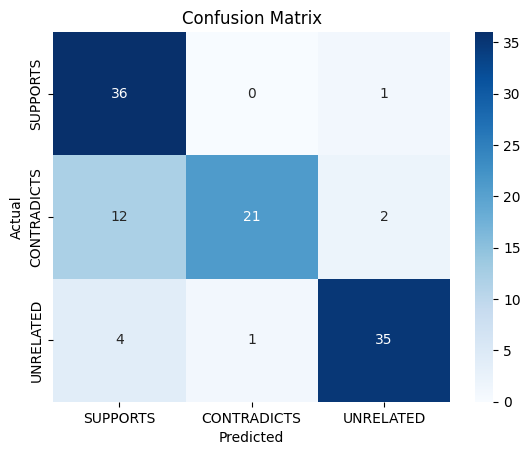

Class: SUPPORTS
Precision: 0.69
Recall: 0.97
Accuracy: 0.84
Confusion Matrix:
[[36 16]
 [ 1 56]]

Class: CONTRADICTS
Precision: 0.95
Recall: 0.60
Accuracy: 0.86
Confusion Matrix:
[[21  1]
 [14 71]]

Class: UNRELATED
Precision: 0.92
Recall: 0.88
Accuracy: 0.92
Confusion Matrix:
[[35  3]
 [ 5 57]]



In [ ]:
### partial support and NEI jawn
# query = "\nGiven a new abstract and claim pair, determine whether the abstract SUPPORTS, PARTIALLY_SUPPORTS, CONTRADICTS, or is UNRELATED to the claim. Lastly, if the abstract is on topic, but there is not enough information to support or contradict the claim, please label it instead as NOT_ENOUGH_INFORMATION. Please return your answer as the first token, as well as an explanation and quote from the abstract supporting the rationale for the answer. \n\tNew abstract: {} \n\tClaim: {}"
calculate_metrics(data)

Total:   112
Matches: 95
Misses:  17
Match rate: 0.8482142857142857
Micro F1 Score: 0.8482
Macro F1 Score: 0.8439
[[35  0  2]
 [ 7 24  4]
 [ 3  1 36]]


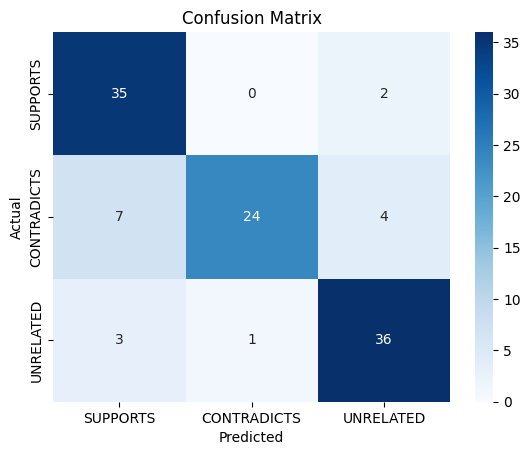

Class: SUPPORTS
Precision: 0.78
Recall: 0.95
Accuracy: 0.89
Confusion Matrix:
[[35 10]
 [ 2 60]]

Class: CONTRADICTS
Precision: 0.96
Recall: 0.69
Accuracy: 0.89
Confusion Matrix:
[[24  1]
 [11 71]]

Class: UNRELATED
Precision: 0.86
Recall: 0.90
Accuracy: 0.90
Confusion Matrix:
[[36  6]
 [ 4 59]]



In [ ]:
calculate_metrics(data)

# Perplexity testing

In [ ]:
device = 'cuda'
model_id = 'gpt2-large'
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)
from scipy import stats

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
citance_perplexity = []
for x in supports:
    encodings = tokenizer(x, return_tensors="pt")

    input_ids = encodings.input_ids.to(device)
    target_ids = input_ids.clone()

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)
        neg_log_likelihood = outputs.loss

    citance_perplexity.append(neg_log_likelihood)
citance_perplexity = [x.item() for x in citance_perplexity]

In [ ]:
negation_perplexity = []
for x in negations:
    encodings = tokenizer(x, return_tensors="pt")

    input_ids = encodings.input_ids.to(device)
    target_ids = input_ids.clone()

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)
        neg_log_likelihood = outputs.loss

    negation_perplexity.append(neg_log_likelihood)
negation_perplexity = [x.item() for x in negation_perplexity]

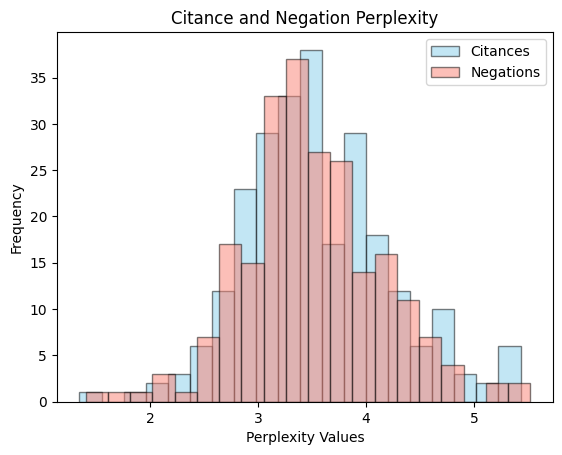

In [ ]:
plt.hist(citance_perplexity, bins=20, color='skyblue', alpha=0.5, label='Distribution 1', edgecolor='black')
plt.hist(negation_perplexity, bins=20, color='salmon', alpha=0.5, label='Distribution 2', edgecolor='black')
plt.xlabel('Perplexity Values')
plt.ylabel('Frequency')
plt.title('Citance and Negation Perplexity')
plt.legend(('Citances', 'Negations'), loc='upper right');
plt.show()

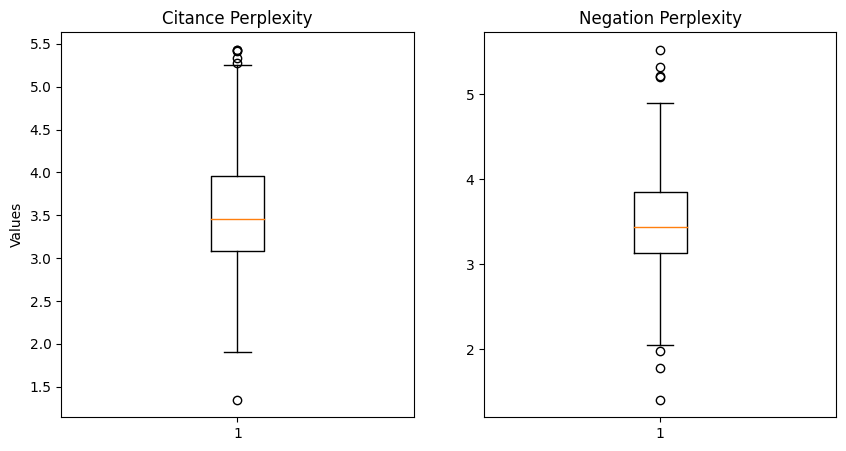

In [ ]:
# plt.boxplot(citance_perplexity)
# plt.boxplot(negation_perplexity)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].boxplot(citance_perplexity)
axs[0].set_title('Citance Perplexity')
axs[0].set_ylabel('Values')

axs[1].boxplot(negation_perplexity)
axs[1].set_title('Negation Perplexity')

plt.show()

In [ ]:
print("Min:", round(np.min(citance_perplexity), 3), "\t", round(np.min(negation_perplexity), 3))
print("Q1: ", round(np.percentile(citance_perplexity, 25), 3), "\t", round(np.percentile(negation_perplexity, 25), 3))
print("Med:", round(np.median(citance_perplexity), 3), "\t", round(np.median(negation_perplexity), 3))
print("Q3: ", round(np.percentile(citance_perplexity, 75), 3), "\t", round(np.percentile(negation_perplexity, 75), 3))
print("Max:", round(np.max(citance_perplexity), 3), "\t", round(np.max(negation_perplexity), 3))

Min: 1.347 	 1.405
Q1:  3.077 	 3.131
Med: 3.46 	 3.432
Q3:  3.954 	 3.851
Max: 5.43 	 5.521


In [ ]:
t_statistic, p_value = stats.ttest_ind(citance_perplexity, negation_perplexity)
temp = stats.ttest_ind(citance_perplexity, negation_perplexity)

print("T-statistic:", t_statistic)
print("P-value:", p_value)
# High p-value so the difference is not statistically significant

T-statistic: 0.7266064493012538
P-value: 0.4678257411891551


In [ ]:
temp.confidence_interval()

ConfidenceInterval(low=-0.07593700477327091, high=0.16504784965684538)

In [ ]:
len(negation_perplexity)

225

# Temperature Testing

In [ ]:
random.seed(22)

intro = "The following are examples of claims from a research paper and the corresponding abstract from the paper they are citing."
supports =  "\nThis is an example of an abstract that SUPPORTS the claim: \n\tSuppporting abstract: {} \n\tClaim: {}"
contradicts = "\nThis is an example of an abstract that CONTRADICTS the claim: \n\tContradicting abstract: {} \n\tClaim: {}"
unrelated = "\nThis is an example of an abstract that is UNRELATED to the claim: \n\tUnrelated abstract: {} \n\tClaim: {}"
query = "\nGiven a new abstract and claim pair, determine whether the abstract SUPPORTS, CONTRADICTS, or is UNRELATED to the claim. Please return your answer as the capitalized token. \n\tNew abstract: {} \n\tClaim: {}"

results = []
fails = []
match_count = 0
miss_count = 0
misses = []

for item in dev:
  time.sleep(5.5)
  key = item['id']
  abstract = corpus[key]['abstract']
  claim = item['claim']
  label = item['label']
  query_string = query.format(abstract, claim)

  k, v = random.choice(list(train_supports.items()))
  supports_claim = v['claim']
  supports_abstract = corpus[k]['abstract']
  supports_string = supports.format(supports_abstract, supports_claim)

  k, v = random.choice(list(train_contradicts.items()))
  contradicts_claim = v['claim']
  contradicts_abstract = corpus[k]['abstract']
  contradicts_string = contradicts.format(contradicts_abstract, contradicts_claim)

  k, v = random.choice(list(train_nei.items()))
  nei_claim = v['claim']
  nei_abstract = corpus[k]['abstract']
  unrelated_string = unrelated.format(nei_abstract, nei_claim)

  temp = [supports_string, contradicts_string, unrelated_string]
  random.shuffle(temp)
  prompt = intro + temp[0] + temp[1] + temp[2] + query_string
  message = [{"role": "user", "content": prompt}]
  try:
    response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.2)
  except Exception as e:
    print(e)
    continue

  predicted = response.choices[0].message.content
  results.append((label, predicted))

NameError: name 'random' is not defined

In [ ]:
calculate_metrics(results)

In [ ]:
random.seed(22)

intro = "The following are examples of claims from a research paper and the corresponding abstract from the paper they are citing."
supports =  "\nThis is an example of an abstract that SUPPORTS the claim: \n\tSuppporting abstract: {} \n\tClaim: {}"
contradicts = "\nThis is an example of an abstract that CONTRADICTS the claim: \n\tContradicting abstract: {} \n\tClaim: {}"
unrelated = "\nThis is an example of an abstract that is UNRELATED to the claim: \n\tUnrelated abstract: {} \n\tClaim: {}"
query = "\nGiven a new abstract and claim pair, determine whether the abstract SUPPORTS, CONTRADICTS, or is UNRELATED to the claim.Please return your answer as the capitalized token. \n\tNew abstract: {} \n\tClaim: {}"

results = []
fails = []
match_count = 0
miss_count = 0
misses = []

for item in dev:
  time.sleep(5.5)
  key = item['id']
  abstract = corpus[key]['abstract']
  claim = item['claim']
  label = item['label']
  query_string = query.format(abstract, claim)

  k, v = random.choice(list(train_supports.items()))
  supports_claim = v['claim']
  supports_abstract = corpus[k]['abstract']
  supports_string = supports.format(supports_abstract, supports_claim)

  k, v = random.choice(list(train_contradicts.items()))
  contradicts_claim = v['claim']
  contradicts_abstract = corpus[k]['abstract']
  contradicts_string = contradicts.format(contradicts_abstract, contradicts_claim)

  k, v = random.choice(list(train_nei.items()))
  nei_claim = v['claim']
  nei_abstract = corpus[k]['abstract']
  unrelated_string = unrelated.format(nei_abstract, nei_claim)

  temp = [supports_string, contradicts_string, unrelated_string]
  random.shuffle(temp)
  prompt = intro + temp[0] + temp[1] + temp[2] + query_string
  message = [{"role": "user", "content": prompt}]
  try:
    response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.2)
  except Exception as e:
    print(e)
    continue

  predicted = response.choices[0].message.content
  results.append((label, predicted))

In [ ]:
calculate_metrics(results)

In [ ]:
## TEMp 0
random.seed(22)

intro = "The following are examples of claims from a research paper and the corresponding abstract from the paper they are citing."
supports =  "\nThis is an example of an abstract that SUPPORTS the claim: \n\tSuppporting abstract: {} \n\tClaim: {}"
contradicts = "\nThis is an example of an abstract that CONTRADICTS the claim: \n\tContradicting abstract: {} \n\tClaim: {}"
unrelated = "\nThis is an example of an abstract that is UNRELATED to the claim: \n\tUnrelated abstract: {} \n\tClaim: {}"
query = "\nGiven a new abstract and claim pair, determine whether the abstract SUPPORTS, CONTRADICTS, or is UNRELATED to the claim.Please return your answer as the capitalized token. \n\tNew abstract: {} \n\tClaim: {}"

results = []
fails = []
match_count = 0
miss_count = 0
misses = []

for item in dev:
  time.sleep(5.5)
  key = item['id']
  abstract = corpus[key]['abstract']
  claim = item['claim']
  label = item['label']
  query_string = query.format(abstract, claim)

  k, v = random.choice(list(train_supports.items()))
  supports_claim = v['claim']
  supports_abstract = corpus[k]['abstract']
  supports_string = supports.format(supports_abstract, supports_claim)

  k, v = random.choice(list(train_contradicts.items()))
  contradicts_claim = v['claim']
  contradicts_abstract = corpus[k]['abstract']
  contradicts_string = contradicts.format(contradicts_abstract, contradicts_claim)

  k, v = random.choice(list(train_nei.items()))
  nei_claim = v['claim']
  nei_abstract = corpus[k]['abstract']
  unrelated_string = unrelated.format(nei_abstract, nei_claim)

  temp = [supports_string, contradicts_string, unrelated_string]
  random.shuffle(temp)
  prompt = intro + temp[0] + temp[1] + temp[2] + query_string
  message = [{"role": "user", "content": prompt}]
  try:
    response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.0)
  except Exception as e:
    print(e)
    continue

  predicted = response.choices[0].message.content
  results.append((label, predicted))

In [ ]:
calculate_metrics(results)

# Final Testing

## 1. Zero-shot / claim only / no unrelated

In [ ]:
for i in range(5):
    random.seed(22)
    query = "Given a claim, please determine whether the existing academic literature SUPPORTS or CONTRADICTS the claim (even if you cannot reference specific abstracts). Please return your answer as only the capitalized token, as well as an explanation or rationale for the answer. \n\tClaim: {}"
    results = []
    for item in test:
        key = item['id']
        abstract = corpus[key]['abstract']
        claim = item['claim']
        label = item['label']
        if label == 'UNRELATED':
          continue
        query_string = query.format(claim)
        message = [{"role": "user", "content": query_string}]
        try:
          response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.2)
        except Exception as e:
          print(e)
          continue
        predicted = response.choices[0].message.content
        results.append((label, predicted))
    obj = json.dumps(results, indent=4)
    with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/zero_claim_only_no_unrelated_{i}.json', 'w') as f:
      f.write(obj)

In [ ]:
labels = ['CONTRADICTS', 'SUPPORTS']
data = []
for x in results:
  label = x[1].split()[:10]
  # label = [''.join(char for char in x if char.isalpha() or char == '_') for x in label]
  matched = False
  for l in labels:
    if l in label:
      label = l
      matched = True
      break
  if not matched:
    label = "UNRELATED"
  data.append((x[0], label))

## 2. Zero-shot / claim and abstract / no unrelated

In [ ]:
for i in range(5):
    random.seed(22)
    query = "Please obey the following: With a specific abstract, please make an estimation whether the abstract SUPPORTS or CONTRADICTS the claim. You must choose SUPPORTS or CONTRADICTS. Please return your answer as only the capitalized token, as well as an explanation or rationale for the answer. \nAbstract: {}\n\tClaim: {}"
    results = []
    for item in test:
        key = item['id']
        abstract = corpus[key]['abstract']
        claim = item['claim']
        label = item['label']
        if label == 'UNRELATED':
          continue
        query_string = query.format(abstract, claim)
        message = [{"role": "user", "content": query_string}]
        try:
          response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.2)
        except Exception as e:
          print(e)
          continue
        predicted = response.choices[0].message.content
        results.append((label, predicted))
    obj = json.dumps(results, indent=4)
    with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/zero_with_abstract_no_unrelated_{i}.json', 'w') as f:
        f.write(obj)

HTTP code 502 from API (<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>
)


## 3. Zero-shot / claim and abstract / with unrelated

In [ ]:
for i in range(5):
    random.seed(22)
    # query = "Please obey the following: With a specific abstract, please make an estimation whether the abstract SUPPORTS or CONTRADICTS the claim, or if there is NOT_ENOUGH_INFO to determine. You must choose SUPPORTS or CONTRADICTS or NOT_ENOUGH_INFO. Please return your answer as only the capitalized token(s), as well as an explanation or rationale for the answer. \nAbstract: {}\n\tClaim: {}"
    query = "Please obey the following: With a specific abstract, please make an estimation whether the abstract SUPPORTS, CONTRADICTS, or is UNRELATED to the claim. You must choose SUPPORTS or CONTRADICTS or UNRELATED. Please return your answer as only the capitalized token, as well as an explanation or rationale for the answer. \nAbstract: {}\n\tClaim: {}"
    results = []
    for item in test:
        key = item['id']
        abstract = corpus[key]['abstract']
        claim = item['claim']
        label = item['label']
        query_string = query.format(abstract, claim)
        message = [{"role": "user", "content": query_string}]
        try:
          response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.2)
        except Exception as e:
          print(e)
          continue
        predicted = response.choices[0].message.content
        results.append((label, predicted))
    obj = json.dumps(results, indent=4)
    with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/zero_with_abstract_with_unrelated_{i}.json', 'w') as f:
        f.write(obj)

In [ ]:
labels = ['CONTRADICTS', 'SUPPORTS', 'UNRELATED']
data = []
for x in results:
  label = x[1].split()[:10]
  # label = [''.join(char for char in x if char.isalpha() or char == '_') for x in label]
  matched = False
  for l in labels:
    if l in label:
      label = l
      matched = True
      break
  data.append((x[0], label))

## 4. Multi-shot / claim only / no unrelated

In [ ]:
for i in range(1):
    random.seed(22)
    intro = "The following are examples of claims from a research paper and the corresponding abstract from the paper they are citing."
    supports =  "\nThis is an example of an abstract that SUPPORTS the claim: \n\tSupporting abstract: {} \n\tClaim: {}"
    contradicts = "\nThis is an example of an abstract that CONTRADICTS the claim: \n\tContradicting abstract: {} \n\tClaim: {}"
    query = "Please obey the following: With no specific abstracts, please make an estimation whether the existing academic literature (and not the abstracts above) SUPPORTS or CONTRADICTS the claim. You must choose SUPPORTS or CONTRADICTS. Please return your answer as only the capitalized token, as well as an explanation or rationale for the answer. \n\tClaim: {}"
    results = []
    for item in test:
        time.sleep(5.5)
        key = item['id']
        abstract = corpus[key]['abstract']
        claim = item['claim']
        label = item['label']
        if label == 'UNRELATED':
          continue
        query_string = query.format(claim)

        k, v = random.choice(list(train_supports.items()))
        supports_claim = v['claim']
        supports_abstract = corpus[k]['abstract']
        supports_string = supports.format(supports_abstract, supports_claim)

        k, v = random.choice(list(train_contradicts.items()))
        contradicts_claim = v['claim']
        contradicts_abstract = corpus[k]['abstract']
        contradicts_string = contradicts.format(contradicts_abstract, contradicts_claim)

        temp = [supports_string, contradicts_string]
        random.shuffle(temp)
        prompt = intro + temp[0] + temp[1] + query_string
        message = [{"role": "user", "content": prompt}]
        try:
          response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.2)
        except Exception as e:
          print(e)
          continue
        predicted = response.choices[0].message.content
        results.append((label, predicted))
    obj = json.dumps(results, indent=4)
    with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/multi_claim_only_no_unrelated_{i}.json', 'w') as f:
        f.write(obj)

In [ ]:
labels = ['CONTRADICTS', 'SUPPORTS']
data = []
for x in results:
  label = x[1].split()[:10]
  # label = [''.join(char for char in x if char.isalpha() or char == '_') for x in label]
  matched = False
  for l in labels:
    if l in label:
      label = l
      matched = True
      break
  if not matched:
    label = "UNRELATED"
  data.append((x[0], label))

## 5. Multi-shot / claim and abstract / no unrelated

In [ ]:
for i in range(5):
    random.seed(22)
    intro = "The following are examples of claims from a research paper and the corresponding abstract from the paper they are citing."
    supports =  "\nThis is an example of an abstract that SUPPORTS the claim: \n\tSupporting abstract: {} \n\tClaim: {}"
    contradicts = "\nThis is an example of an abstract that CONTRADICTS the claim: \n\tContradicting abstract: {} \n\tClaim: {}"
    query = "\nPlease obey the following: given a new abstract and claim pair, please make an estimation whether the abstract SUPPORTS or CONTRADICTS the claim. You must choose SUPPORTS or CONTRADICTS. Please return your answer as the capitalized token, as well as an explanation or rationale for the answer. \n\tNew abstract: {} \n\tClaim: {}"
    results = []
    for item in test:
        time.sleep(5.5)
        key = item['id']
        abstract = corpus[key]['abstract']
        claim = item['claim']
        label = item['label']
        if label == 'UNRELATED':
          continue
        query_string = query.format(abstract, claim)

        k, v = random.choice(list(train_supports.items()))
        supports_claim = v['claim']
        supports_abstract = corpus[k]['abstract']
        supports_string = supports.format(supports_abstract, supports_claim)

        k, v = random.choice(list(train_contradicts.items()))
        contradicts_claim = v['claim']
        contradicts_abstract = corpus[k]['abstract']
        contradicts_string = contradicts.format(contradicts_abstract, contradicts_claim)

        temp = [supports_string, contradicts_string]
        random.shuffle(temp)
        prompt = intro + temp[0] + temp[1] + query_string
        message = [{"role": "user", "content": prompt}]
        try:
          response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.2)
        except Exception as e:
          print(e)
          continue
        predicted = response.choices[0].message.content
        results.append((label, predicted))
    obj = json.dumps(results, indent=4)
    with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/multi_with_abstract_no_unrelated_{i}.json', 'w') as f:
      f.write(obj)

In [ ]:
labels = ['CONTRADICTS', 'SUPPORTS']
data = []
for x in results:
  label = x[1].split()[:10]
  # label = [''.join(char for char in x if char.isalpha() or char == '_') for x in label]
  matched = False
  for l in labels:
    if l in label:
      label = l
      matched = True
      break
  if not matched:
    label = "UNRELATED"
  data.append((x[0], label))

## 6. Multi-shot / claim and abstract / with unrelated

In [ ]:
for i in range(5):
    random.seed(22)
    intro = "The following are examples of claims from a research paper and the corresponding abstract from the paper they are citing."
    supports =  "\nThis is an example of an abstract that SUPPORTS the claim: \n\tSupporting abstract: {} \n\tClaim: {}"
    contradicts = "\nThis is an example of an abstract that CONTRADICTS the claim: \n\tContradicting abstract: {} \n\tClaim: {}"
    unrelated = "\nThis is an example of an abstract that is UNRELATED to the claim: \n\tUnrelated abstract: {} \n\tClaim: {}"
    query = "\nPlease obey the following: given a new abstract and claim pair, please make an estimation whether the abstract SUPPORTS, CONTRADICTS, or is UNRELATED to the claim. You must choose SUPPORTS or CONTRADICTS or UNRELATED. Please return your answer as the capitalized token, as well as an explanation or rationale for the answer. \n\tNew abstract: {} \n\tClaim: {}"
    # nei = "\nThis is an example of an abstract with NOT_ENOUGH_INFO about the claim: \n\tMissing info abstract: {} \n\tClaim: {}"
    # query = "\nPlease obey the following: given a new abstract and claim pair, please make an estimation whether the abstract SUPPORTS or CONTRADICTS the claim, or if there is NOT_ENOUGH_INFO to determine. You must choose SUPPORTS or CONTRADICTS or NOT_ENOUGH_INFO. Please return your answer as the capitalized token(s), as well as an explanation or rationale for the answer. \n\tNew abstract: {} \n\tClaim: {}"

    results = []
    for item in test:
        time.sleep(5.5)
        key = item['id']
        abstract = corpus[key]['abstract']
        claim = item['claim']
        label = item['label']
        query_string = query.format(abstract, claim)

        k, v = random.choice(list(train_supports.items()))
        supports_claim = v['claim']
        supports_abstract = corpus[k]['abstract']
        supports_string = supports.format(supports_abstract, supports_claim)

        k, v = random.choice(list(train_contradicts.items()))
        contradicts_claim = v['claim']
        contradicts_abstract = corpus[k]['abstract']
        contradicts_string = contradicts.format(contradicts_abstract, contradicts_claim)

        k, v = random.choice(list(train_nei.items()))
        nei_claim = v['claim']
        nei_abstract = corpus[k]['abstract']
        unrelated_string = nei.format(nei_abstract, nei_claim) # Change for NEI ablation

        temp = [supports_string, contradicts_string, unrelated_string]
        random.shuffle(temp)
        prompt = intro + temp[0] + temp[1] + temp[2] + query_string
        message = [{"role": "user", "content": prompt}]
        try:
          response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.2)
        except Exception as e:
          print(e)
          continue
        predicted = response.choices[0].message.content
        results.append((label, predicted))
    obj = json.dumps(results, indent=4)
    with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/nei_ablation/multi_with_abstract_with_nei_{i}.json', 'w') as f: # Change for NEI ablation
      f.write(obj)


# Table Generation

In [ ]:
exps = ['zero_claim_only_no_unrelated',
        'zero_with_abstract_no_unrelated',
        'zero_with_abstract_with_unrelated',
        'multi_claim_only_no_unrelated',
        'multi_with_abstract_no_unrelated',
        'multi_with_abstract_with_unrelated',
        'scifact_baseline']

In [ ]:
nei_exps = ['nei_ablation/zero_with_abstract_with_nei',
            'nei_ablation/multi_with_abstract_with_nei',
            'nei_ablation/scifact_baseline_with_nei']

In [ ]:
nei_exps = ['nei_ablation/scifact_baseline_with_nei_zeroshot']

In [ ]:
with open('/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/' + 'nei_ablation/scifact_baseline_zeroshot' + '_4.json') as f: # this is where i atone for my sins
      items = json.load(f)
for i in range(len(items)):
  if items[i][0] == 'UNRELATED':
    items[i][0] = 'NOT_ENOUGH_INFO'
res = json.dumps(items, indent=4)
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/nei_ablation/scifact_baseline_with_nei_zeroshot_4.json', 'w') as f:
      f.write(res)

zero_claim_only_no_unrelated
Counter({'C': 3, 'S': 1})


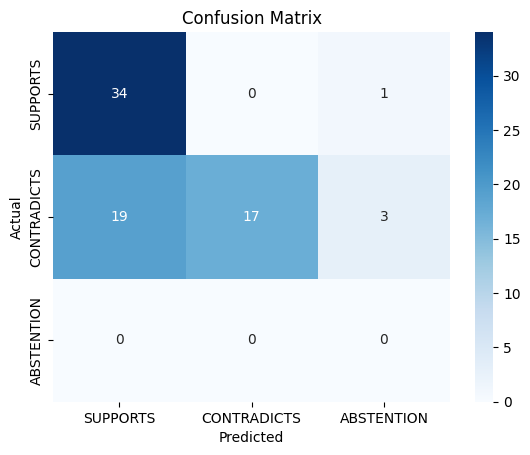

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Counter({'C': 5, 'S': 1})


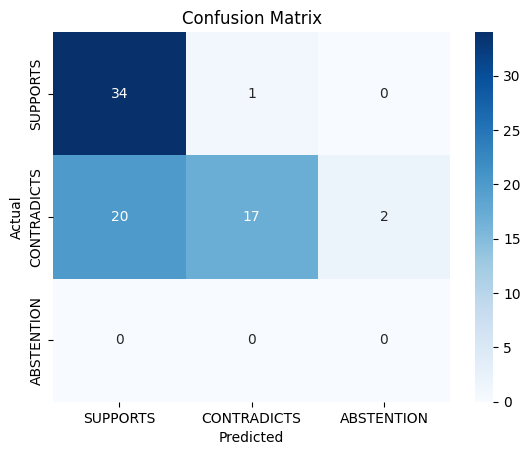

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Counter({'C': 8, 'S': 3})


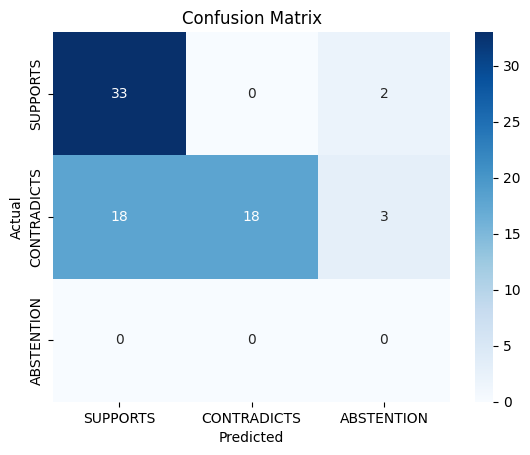

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Counter({'C': 9, 'S': 5})


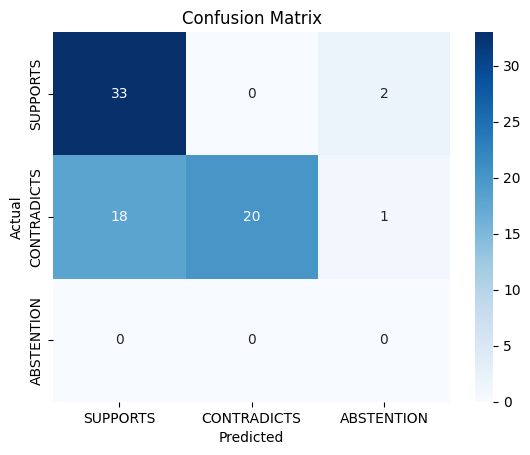

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Counter({'C': 11, 'S': 7})


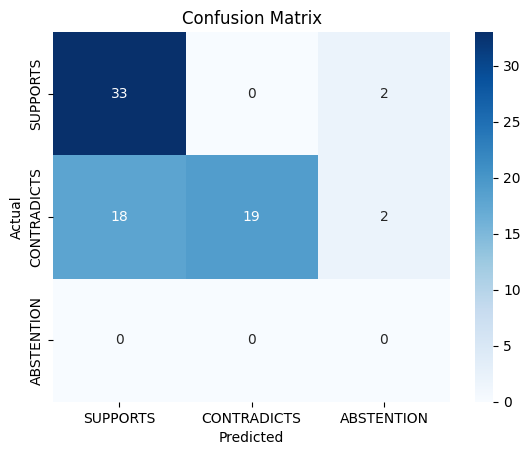

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
results = {}
c = Counter()
for exp in exps:
    print(exp)
    final_avgs = []
    abstentions = 0
    total = 0
    for i in range(5):
        with open('/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/' + exp + f'_{i}.json') as f:
            items = json.load(f)
        if 'no_unrelated' in exp:
            labels = ['CONTRADICTS', 'SUPPORTS']
        else:
            labels = ['CONTRADICTS', 'SUPPORTS', 'UNRELATED']
        data = []
        for x in items:
            total += 1
            label = x[1].split()[:10]
            # print(label)
            matched = False
            for l in labels:
                if l in [re.sub(r'[^\w\s]', '', x) for x in label]:
                    label = l
                    matched = True
                    # print(x)
                    # print(label)
                    # print()
                    break
            if not matched:
                # print(x)
                abstentions += 1
                label = 'ABSTENTION'
            data.append((x[0], label))
        for d in data:
            if d[1] == 'ABSTENTION':
                c.update(d[0][0])
        print(c)
        final_avgs.append(table_metrics(data, 'no_unrelated' in exp))
        temp = [mean([x[n] for x in final_avgs]) for n in range(len(final_avgs[0]))]
        temp.append((abstentions, total))
        results[exp] = temp
    print()
    break

In [ ]:
"""
Micro F1
Macro F1
Macro Precision
Macro Recall
"""
results

{'zero_claim_only_no_unrelated': [0.6972972972972973,
  0.46716328973415455,
  0.5437839985749715,
  0.4736507936507936,
  (18, 370)],
 'zero_with_abstract_no_unrelated': [0.8807108478341356,
  0.8806652095498526,
  0.8811838153943417,
  0.8820859841912473,
  (0, 369)],
 'zero_with_abstract_with_unrelated': [0.7969625879738239,
  0.7812292953223959,
  0.7822056127234396,
  0.7940936334047789,
  (0, 453)],
 'multi_claim_only_no_unrelated': [0.7162162162162162,
  0.709156162464986,
  0.7605464638685663,
  0.7266666666666667,
  (0, 370)],
 'multi_with_abstract_no_unrelated': [0.8675675675675676,
  0.8674484974707362,
  0.8674766872135293,
  0.8684981684981685,
  (0, 370)],
 'multi_with_abstract_with_unrelated': [0.778021978021978,
  0.7456938492880131,
  0.761148570474891,
  0.7462127415068591,
  (0, 455)],
 'scifact_baseline': [0.8370588235294117,
  0.8316499435605341,
  0.8327175058394273,
  0.8341246357074481,
  (0, 1700)]}

In [ ]:
api_errors = 0
total = 0
exp1 = []
for i in range(5):
    with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/zero_claim_only_no_unrelated_{i}.json') as f:
        items = json.load(f)
    labels = ['CONTRADICTS', 'SUPPORTS']
    data = []
    for x in items:
        total += 1
        label = x[1].split()[:10]
        # label = [''.join(char for char in x if char.isalpha() or char == '_') for x in label]
        matched = False
        for l in labels:
            if l in label:
                label = l
                matched = True
                break
        if not matched:
            api_errors += 1
            continue
        data.append((x[0], label))
    exp1.append(table_metrics(data))
    print()

Total:   70
Matches: 51
Misses:  19
Match rate: 0.7285714285714285
[1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]
Micro F1 Score: 0.7816
Macro F1 Score: 0.7116
Micro Pr Score: 0.6415
Micro Re Score: 1.0000

Total:   72
Matches: 51
Misses:  21
Match rate: 0.7083333333333334
[1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1

# SciFact Dev Baseline

In [ ]:
corpus = {}
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/scifact_testing/corpus.jsonl') as f_pdf:
    for line in f_pdf:
        pdf_parse_dict = json.loads(line)
        corpus[pdf_parse_dict['doc_id']] = pdf_parse_dict

train = [] ## array of dict {claim, label, id}
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/scifact_testing/claims_train.jsonl') as f_pdf:
    for line in f_pdf:
        parse = json.loads(line)
        # {'id': 0, 'claim': '0-dimensional biomaterials lack inductive properties.', 'evidence': {}, 'cited_doc_ids': [31715818]}
        for id in parse['cited_doc_ids']:
          if str(id) not in parse['evidence']:
            train.append({
                'claim': parse['claim'],
                'label': "UNRELATED",
                'id': id
            })
          else:
            train.append({
                'claim': parse['claim'],
                'label': parse['evidence'][str(id)][0]['label'] + "S",
                'id': id
            })

test = []
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/scifact_testing/claims_dev.jsonl') as f_pdf:
    for line in f_pdf:
        parse = json.loads(line)
        # {'id': 0, 'claim': '0-dimensional biomaterials lack inductive properties.', 'evidence': {}, 'cited_doc_ids': [31715818]}
        for id in parse['cited_doc_ids']:
          if str(id) not in parse['evidence']:
            test.append({
                'claim': parse['claim'],
                'label': "UNRELATED",
                'id': id
            })
          else:
            test.append({
                'claim': parse['claim'],
                'label': parse['evidence'][str(id)][0]['label'] + "S",
                'id': id
            })

train_supports = []
train_contradicts = []
train_nei = []
for item in train:
  if item['label'] == 'SUPPORTS':
    train_supports.append(item)
  if item['label'] == 'CONTRADICTS':
    train_contradicts.append(item)
  if item['label'] == "UNRELATED":
    train_nei.append(item)

KeyError: 'evidence'

In [ ]:
for i in range(1, 5):
    random.seed(22)

    # intro = "The following are examples of claims from a research paper and the corresponding abstract from the paper they are citing."
    # supports =  "\nThis is an example of an abstract that SUPPORTS the claim: \n\tSuppporting abstract: {} \n\tClaim: {}"
    # contradicts = "\nThis is an example of an abstract that CONTRADICTS the claim: \n\tContradicting abstract: {} \n\tClaim: {}"
    # unrelated = "\nThis is an example of an abstract that is UNRELATED to the claim: \n\tUnrelated abstract: {} \n\tClaim: {}"
    # unrelated = "\nThis is an example of an abstract with NOT_ENOUGH_INFO about the claim: \n\tMissing info abstract: {} \n\tClaim: {}"
    # query = "\nPlease obey the following: given a new abstract and claim pair, please make an estimation whether the abstract SUPPORTS or CONTRADICTS the claim, or if there is NOT_ENOUGH_INFO to determine. You must choose SUPPORTS or CONTRADICTS or NOT_ENOUGH_INFO. Please return your answer as the capitalized token(s), as well as an explanation or rationale for the answer. \n\tNew abstract: {} \n\tClaim: {}"
    query = "Please obey the following: With a specific abstract, please make an estimation whether the abstract SUPPORTS, CONTRADICTS, or if there is NOT_ENOUGH_INFO to determine. You must choose SUPPORTS or CONTRADICTS or NOT_ENOUGH_INFO. Please return your answer as only the capitalized token, as well as an explanation or rationale for the answer. \n\tAbstract: {} \n\tClaim: {}"
    # query = "\nPlease obey the following: given a new abstract and claim pair, please make an estimation whether the abstract SUPPORTS, CONTRADICTS, or is UNRELATED to the claim. You must choose SUPPORTS or CONTRADICTS or UNRELATED. Please return your answer as the capitalized token, as well as an explanation or rationale for the answer. \n\tNew abstract: {} \n\tClaim: {}"

    results = []

    for item in test: #TODO HUH
      time.sleep(3.5)
      key = item['id']
      abstract = corpus[key]['abstract']
      claim = item['claim']
      label = item['label']
      query_string = query.format(abstract, claim)

      # v = random.choice(train_supports)
      # supports_claim = v['claim']
      # supports_abstract = corpus[v['id']]['abstract']
      # supports_string = supports.format(supports_abstract, supports_claim)

      # v = random.choice(train_contradicts)
      # contradicts_claim = v['claim']
      # contradicts_abstract = corpus[v['id']]['abstract']
      # contradicts_string = contradicts.format(contradicts_abstract, contradicts_claim)

      # v = random.choice(train_nei)
      # nei_claim = v['claim']
      # nei_abstract = corpus[v['id']]['abstract']
      # unrelated_string = unrelated.format(nei_abstract, nei_claim)

      # temp = [supports_string, contradicts_string, unrelated_string]
      # random.shuffle(temp)
      # prompt = intro + temp[0] + temp[1] + temp[2] + query_string
      prompt = query_string
      message = [{"role": "user", "content": prompt}]
      try:
        response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.2)
      except Exception as e:
        print(e)
        continue

      predicted = response.choices[0].message.content
      results.append((label, predicted))

    obj = json.dumps(results, indent=4)
    with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/nei_ablation/scifact_baseline_zeroshot_{i}.json', 'w') as f:
      f.write(obj)

HTTP code 502 from API (<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>
)


In [ ]:
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/final/scifact_baseline_0.json') as f:
    results = json.load(f)

In [ ]:
labels = ['CONTRADICTS', 'SUPPORTS', 'UNRELATED']
data = []
for x in results:
  label = x[1].split()[:10]
  label = [''.join(char for char in x if char.isalpha() or char == '_') for x in label]
  matched = False
  for l in labels:
    if l in label:
      label = l
      matched = True
      break
  data.append((x[0], label))

Total:   340
Matches: 286
Misses:  54
Match rate: 0.8411764705882353
Micro F1 Score: 0.8412
Macro F1 Score: 0.8362
[[124   4  10]
 [  8  59   4]
 [ 17  11 103]]


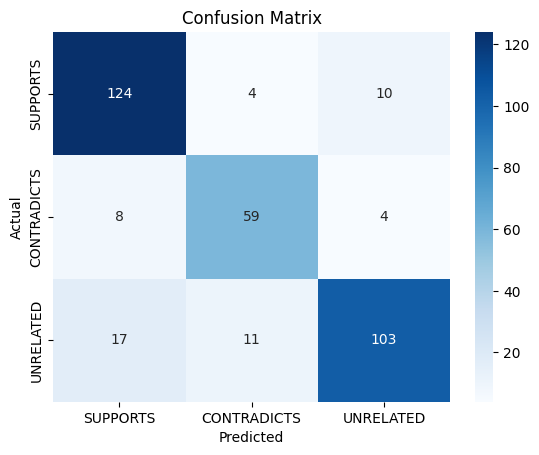

Class: SUPPORTS
Precision: 0.83
Recall: 0.90
Accuracy: 0.88
Confusion Matrix:
[[124  25]
 [ 14 162]]

Class: CONTRADICTS
Precision: 0.80
Recall: 0.83
Accuracy: 0.91
Confusion Matrix:
[[ 59  15]
 [ 12 227]]

Class: UNRELATED
Precision: 0.88
Recall: 0.79
Accuracy: 0.87
Confusion Matrix:
[[103  14]
 [ 28 183]]



In [ ]:
# 1
calculate_metrics(data)

# SciFact Test Baseline

In [ ]:
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/negations_with_scores_gpt4.json') as f:
    items = json.load(f)
negation_to_claim = {}
results = []
for k in items:
  results.append((k, items[k][0], items[k][1]))
  negation_to_claim[items[k][0]] = k

negations_set = set() ## negation dictionary for processing
for result in results:
  if len(result[2]) < 4 and int(result[2]) >= 90:
    negations_set.add(result[1])


In [ ]:
corpus = {}

with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/dataset/corpus.jsonl') as f_pdf: ###### WILL NEED TO CHANGE NAMES
    for line in f_pdf:
        pdf_parse_dict = json.loads(line)
        corpus[pdf_parse_dict['doc_id']] = pdf_parse_dict

with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/scifact_testing/corpus.jsonl') as f_pdf:
    for line in f_pdf:
        pdf_parse_dict = json.loads(line)
        corpus[pdf_parse_dict['doc_id']] = pdf_parse_dict



train = []
nei = 'NOT_ENOUGH_INFO' # TODO: THIS MIGHT NEED TO BE CHANGED
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/dataset/train.jsonl') as f_pdf:
    for line in f_pdf:
        parse = json.loads(line)
        for i in range(len(parse['doc_ids'])):
          if str(parse['doc_ids'][i]) in parse['evidence']:
            if parse['evidence'][str(parse['doc_ids'][i])][0]['label'] + 'S' == "CONTRADICTS" and parse['claim'] not in negations_set: ## negation checker
              continue
            temp = {
                'claim': parse['claim'],
                'label': parse['evidence'][str(parse['doc_ids'][i])][0]['label'] + 'S',
                'id': str(parse['doc_ids'][i])
            }
          else:
            temp = {
                'claim': parse['claim'],
                'label': nei,
                'id': str(parse['doc_ids'][i])
            }
          train.append(temp)


# train = [] ## array of dict {claim, label, id}
# with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/scifact_testing/claims_train.jsonl') as f_pdf: ##SCIFACT ICL
#     for line in f_pdf:
#         parse = json.loads(line)
#         # {'id': 0, 'claim': '0-dimensional biomaterials lack inductive properties.', 'evidence': {}, 'cited_doc_ids': [31715818]}
#         for id in parse['cited_doc_ids']:
#           if str(id) not in parse['evidence']:
#             train.append({
#                 'claim': parse['claim'],
#                 'label': "NOT_ENOUGH_INFO",
#                 'id': id
#             })
#           else:
#             train.append({
#                 'claim': parse['claim'],
#                 'label': parse['evidence'][str(id)][0]['label'] + "S",
#                 'id': id
#             })

test = []
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/scifact_test/test_with_doc_ids_top_3.jsonl') as f_pdf:
    for line in f_pdf:
        parse = json.loads(line)
        # {'id': 0, 'claim': '0-dimensional biomaterials lack inductive properties.', 'evidence': {}, 'cited_doc_ids': [31715818]}
        for id in parse['cited_doc_ids']:
            test.append({
                'claim': parse['claim'],
                'id': id,
                'claim_id': parse['id']
            })

train_supports = []
train_contradicts = []
train_nei = []
for item in train:
  if item['label'] == 'SUPPORTS':
    train_supports.append(item)
  if item['label'] == 'CONTRADICTS':
    train_contradicts.append(item)
  if item['label'] == "NOT_ENOUGH_INFO":
    train_nei.append(item)

In [ ]:
test[0]

{'claim': '10-20% of people with severe mental disorder receive no treatment in low and middle income countries.',
 'id': 6490571,
 'claim_id': 7}

In [ ]:
for i in range(1):
    random.seed(22)

    # intro = "The following are examples of claims from a research paper and the corresponding abstract from the paper they are citing."
    # supports =  "\nThis is an example of an abstract that SUPPORTS the claim: \n\tSuppporting abstract: {} \n\tClaim: {}"
    # contradicts = "\nThis is an example of an abstract that CONTRADICTS the claim: \n\tContradicting abstract: {} \n\tClaim: {}"
    # # unrelated = "\nThis is an example of an abstract that is UNRELATED to the claim: \n\tUnrelated abstract: {} \n\tClaim: {}"
    # unrelated = "\nThis is an example of an abstract with NOT_ENOUGH_INFO about the claim: \n\tMissing info abstract: {} \n\tClaim: {}"
    query = "\nPlease obey the following: given a new abstract and claim pair, please make an estimation whether the abstract SUPPORTS or CONTRADICTS the claim, or if there is NOT_ENOUGH_INFO to determine. You must choose SUPPORTS or CONTRADICTS or NOT_ENOUGH_INFO. Please return your answer with the capitalized token(s) at the beginning of the response. Also provide an explanation or rationale for the answer. \n\tAbstract: {} \n\tClaim: {}"
    # query = "Please obey the following: With a specific abstract, please make an estimation whether the abstract SUPPORTS, CONTRADICTS, or if there is NOT_ENOUGH_INFO to determine. You must choose SUPPORTS or CONTRADICTS or NOT_ENOUGH_INFO. Please return your answer as only the capitalized token, as well as an explanation or rationale for the answer. \n\tAbstract: {} \n\tClaim: {}"
    # query = "\nPlease obey the following: given a new abstract and claim pair, please make an estimation whether the abstract SUPPORTS, CONTRADICTS, or is UNRELATED to the claim. You must choose SUPPORTS or CONTRADICTS or UNRELATED. Please return your answer as the capitalized token, as well as an explanation or rationale for the answer. \n\tNew abstract: {} \n\tClaim: {}"

    # results = []
    errors = 0

    for item in test:
        time.sleep(2)
        doc_id = item['id']
        claim_id = item['claim_id']
        abstract = corpus[doc_id]['abstract']
        claim = item['claim']
        query_string = query.format(abstract, claim)

        # v = random.choice(train_supports)
        # supports_claim = v['claim']
        # supports_abstract = corpus[int(v['id'])]['abstract']
        # supports_string = supports.format(supports_abstract, supports_claim)

        # v = random.choice(train_contradicts)
        # contradicts_claim = v['claim']
        # contradicts_abstract = corpus[int(v['id'])]['abstract']
        # contradicts_string = contradicts.format(contradicts_abstract, contradicts_claim)

        # v = random.choice(train_nei)
        # nei_claim = v['claim']
        # nei_abstract = corpus[int(v['id'])]['abstract']
        # unrelated_string = unrelated.format(nei_abstract, nei_claim)

        # temp = [supports_string, contradicts_string, unrelated_string]
        # random.shuffle(temp)
        # prompt = intro + temp[0] + temp[1] + temp[2] + query_string
        prompt = query_string
        message = [{"role": "user", "content": prompt}]
        try:
            response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.2)
        except Exception as e:
            print(e)
            errors += 1
            print(item)
            print()
            continue

        predicted = response.choices[0].message.content
        # print(claim_id, predicted)
        result = (claim_id, doc_id, predicted)
        try:
            with open('/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/scifact_test/no_icl_0.json', "r") as f:
                results = json.load(f)
        except Exception as e:
            print(e)
            print("should happen exactly once lol ^\n")
            # There was no file (first loop)
            results = []
        results.append(result)
        obj = json.dumps(results, indent=4)
        with open('/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/scifact_test/no_icl_0.json', "w") as f:
                f.write(obj)
print("Finished!")
print("OpenAI API Errors:", errors)

[Errno 2] No such file or directory: '/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/scifact_test/no_icl_0.json'
should happen exactly once lol ^

Finished!
OpenAI API Errors: 0


In [ ]:
with open('/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/scifact_test/no_icl_0.json', "r") as f:
    items = json.load(f)

results = {}

for x in items:
    resp = x[2].split()[:10] # First ten words
    label = ""
    doc_id = x[1]
    claim_id = x[0]

    resp = [re.sub(r'[^\w\s]', '', word) for word in resp]

    if "SUPPORTS" in resp:
        label = "SUPPORT"
    elif "CONTRADICTS" in resp:
        label = "CONTRADICT"
    elif "NOT_ENOUGH_INFO" in resp:
        if claim_id in results:
            continue
        results[claim_id] = {
            'id': claim_id,
            'evidence': {}
        }
        continue
    else:
        errors += 1
        print("error with claim", str(claim_id))
        continue
    if claim_id not in results:
        results[claim_id] = {
            'id': claim_id,
            'evidence': {str(doc_id): {'sentences': [0], 'label': label}}
        }
    else:
        results[claim_id]['evidence'][str(doc_id)] = {'sentences': [0], 'label': label}
c = Counter()
for key in results:
    if results[key]['evidence']:
        for doc_id in results[key]['evidence']:
            c.update(results[key]['evidence'][doc_id]['label'][0])
            break
    else:
        c.update("N")
print(c)
with open('/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/scifact_test/no_icl_0.jsonl', "w") as f:
    for key in results:
        json_item = json.dumps(results[key])
        f.write(json_item + "\n")
print('JSONL saved.')

Counter({'C': 113, 'N': 94, 'S': 93})
JSONL saved.


In [ ]:
with open('/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/scifact_test/our_icl_0.json', "r") as f:
    items = json.load(f)
labels = ['CONTRADICTS', 'SUPPORTS', "NOT_ENOUGH_INFO"]
data = []
label_errors = 0
for x in items:
    label = x[2].split()[:10]
    label = [''.join(char for char in x if char.isalpha() or char == '_') for x in label]
    matched = False
    for l in labels:
        if l in label:
            label = l
            matched = True
            break
    if not matched:
        print(x)
        api_errors += 1
        continue
    data.append((x[0], x[1], label))
print("Label errors:", label_errors)
c = Counter()
c.update([x[2] for x in data])
c

Label errors: 0


Counter({'CONTRADICTS': 144, 'NOT_ENOUGH_INFO': 620, 'SUPPORTS': 136})

In [ ]:
# corpus = {}
# with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/scifact_testing/corpus.jsonl') as f_pdf:
#     for line in f_pdf:
#         pdf_parse_dict = json.loads(line)
#         corpus[pdf_parse_dict['doc_id']] = pdf_parse_dict


arr = []
with open('/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/scifact_test/scifact_test_baseline_multishot_ourICL_WITHALLCLAIMS2.jsonl', "r") as f:
    for line in f:
        parse = json.loads(line)
        arr.append(parse)
i = 0
for item in arr:
  if item['evidence']:
    for key in item['evidence']:
        if item['evidence'][key]['label'] == "REFUTES":
            item['evidence'][key]['label'] = "CONTRADICT"

print(i)

JSONDecodeError: Expecting value: line 2 column 1 (char 2)

In [ ]:
arr

[{'id': 7, 'evidence': {'6490571': {'sentences': [0], 'label': 'SUPPORT'}}},
 {'id': 8, 'evidence': {}},
 {'id': 16, 'evidence': {}},
 {'id': 23, 'evidence': {}},
 {'id': 29,
  'evidence': {'24341590': {'sentences': [0], 'label': 'CONTRADICT'},
   '13069283': {'sentences': [0], 'label': 'CONTRADICT'}}},
 {'id': 31, 'evidence': {'12428497': {'sentences': [0], 'label': 'SUPPORT'}}},
 {'id': 33, 'evidence': {'11705328': {'sentences': [0], 'label': 'SUPPORT'}}},
 {'id': 38, 'evidence': {}},
 {'id': 59, 'evidence': {'4709641': {'sentences': [0], 'label': 'SUPPORT'}}},
 {'id': 65, 'evidence': {}},
 {'id': 83, 'evidence': {'18064113': {'sentences': [0], 'label': 'SUPPORT'}}},
 {'id': 84,
  'evidence': {'22406695': {'sentences': [0], 'label': 'SUPPORT'},
   '7521113': {'sentences': [0], 'label': 'SUPPORT'},
   '12827098': {'sentences': [0], 'label': 'SUPPORT'}}},
 {'id': 87,
  'evidence': {'7521113': {'sentences': [0], 'label': 'SUPPORT'},
   '12827098': {'sentences': [0], 'label': 'SUPPORT'}}

In [ ]:
with open('/content/gdrive/MyDrive/Independent study - Max & Carlos/data/results/scifact_test/scifact_test_baseline_multishot_ourICL.jsonl', "w") as f:
    for item in arr:
        json_item = json.dumps(item)
        f.write(json_item + "\n")